# Processing scRNA-seq Data
* Preprocessing Clayton's VANTAGE data using `dropkick` to determine quality of data
* Integrating and correcting reference cell lines with AW data using `scanorama`
Adapted from: https://github.com/smgroves/Groves-CellSys2021/blob/main/notebooks/single-cell/cell-lines/1-Human_cell_lines_preprocessing.ipynb

In [2]:
import os
import sys
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import dropkick as dk
import cellrank as cr
import scanorama
from mazebox_filter import dropkick_filter, dropkick_recipe, doublet_detections

###  Read in counts data

In [3]:
# Load data
REF_DATA = '/mnt/monica/quaranta/Data/RNAseq/SCLC_data/SCLC_scRNAseq/SCLC-human-cell-lines-Vanderbilt/adata_no_doublets_02.h5ad'
ref_adata = sc.read_h5ad(REF_DATA)

MTX_DIR = '/mnt/monica/quaranta2/Sequence_data_from_VANTAGE/CW-AW_data/processed_data_Qi_Liu'
sample_names = os.listdir(MTX_DIR)
sample_names.sort()
sample_names = sample_names[2:12]

| Sample Info | Output Dir |
| ------------| ------------|
| S1 H841_KOR  | 8056-AW-0001 |
| S2 H841_RESTko | 8056-AW-0002 |
| S3 H841_Hes1ko | 8056-AW-0003 | 
| S4 H841_NR0B1ko | 8056-AW-0004 |
| S5 H841_ELF3ko | 8056-AW-0005 |
| S1 DMS53_KOR | 8056-AW-0006 |
| S2 DMS53_RESTko | 8056-AW-0007 |
| S3 DMS53_Hes1ko | 8056-AW-0008 |
| S4 DMS53_NR0B1ko | 8056-AW-0009 |
| S5 DMS53_ELF3ko | 8056-AW-0010 |

In [4]:
# H841 - samples[0:5]
# DMS53 - samples[5:10]
cache = False
cache_compression = None
samples = []

for sample in sample_names[5:10]:
    print(sample)
    s = sc.read(
        f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_counts.mtx',
        cache=cache,
        cache_compression=cache_compression,
    ).T
    
    genes = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_features.tsv', header=None, sep='\t')
    s.var_names = genes[0]
    # s.var['gene_symbols'] = genes[1].values
    s.obs_names = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_barcodes.tsv', header=None)[0]
    print(s)
    samples.append(s)

8056-AW-0006
AnnData object with n_obs × n_vars = 12622 × 25828
8056-AW-0007
AnnData object with n_obs × n_vars = 13303 × 25856
8056-AW-0008
AnnData object with n_obs × n_vars = 5038 × 24030
8056-AW-0009
AnnData object with n_obs × n_vars = 7962 × 26426
8056-AW-0010
AnnData object with n_obs × n_vars = 10536 × 26090


In [5]:
total_cells = 0
for i,a in enumerate(samples):
    print(sample_names[i+5])
    print(a.X.shape)
    total_cells += a.X.shape[0]
print("Total cells: ", total_cells)

8056-AW-0006
(12622, 25828)
8056-AW-0007
(13303, 25856)
8056-AW-0008
(5038, 24030)
8056-AW-0009
(7962, 26426)
8056-AW-0010
(10536, 26090)
Total cells:  49461


In [6]:
s1, s2, s3, s4, s5 = samples

### Plot QC metrics
Simple preprocessing of anndata object to get metrics for plot. Running on each sample to determine quality and filtering for each sample before integrating.

**S1 DMS53_KOR (control)** 

In [11]:
adata1 = dk.recipe_dropkick(s1, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 5.997 and 18.349 percent:
	['LINC00486', 'MT-ND4', 'CALCA', 'SEC11C', 'CGA', 'MT-ND1', 'MT-CO1', 'BCOR', 'MT-CYB', 'RP5-857K21.4']


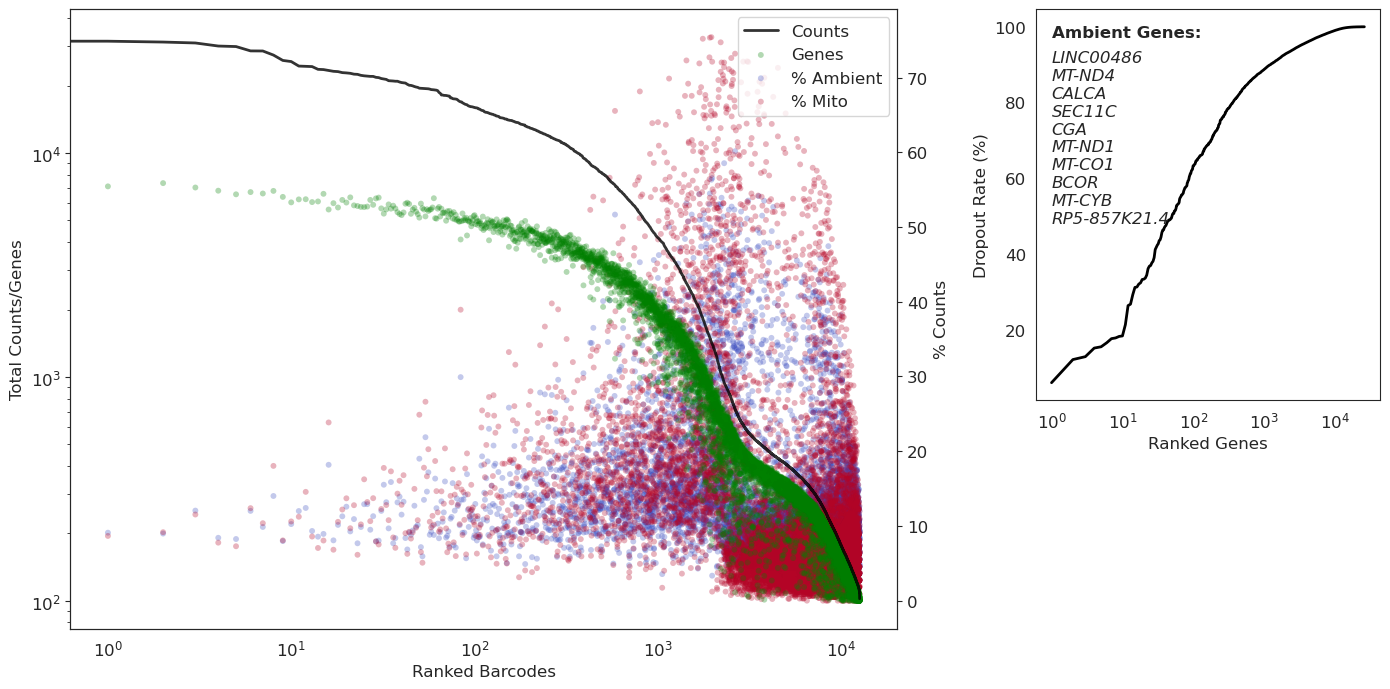

In [12]:
qc_plt1 = dk.qc_summary(adata1)

**S2 DMS53_RESTko**

In [17]:
a2 = dk.recipe_dropkick(s2, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 1.511 and 10.862 percent:
	['MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'LINC00486', 'MT-CYB', 'MT-ATP6', 'MT-RNR2', 'MT-ND2']


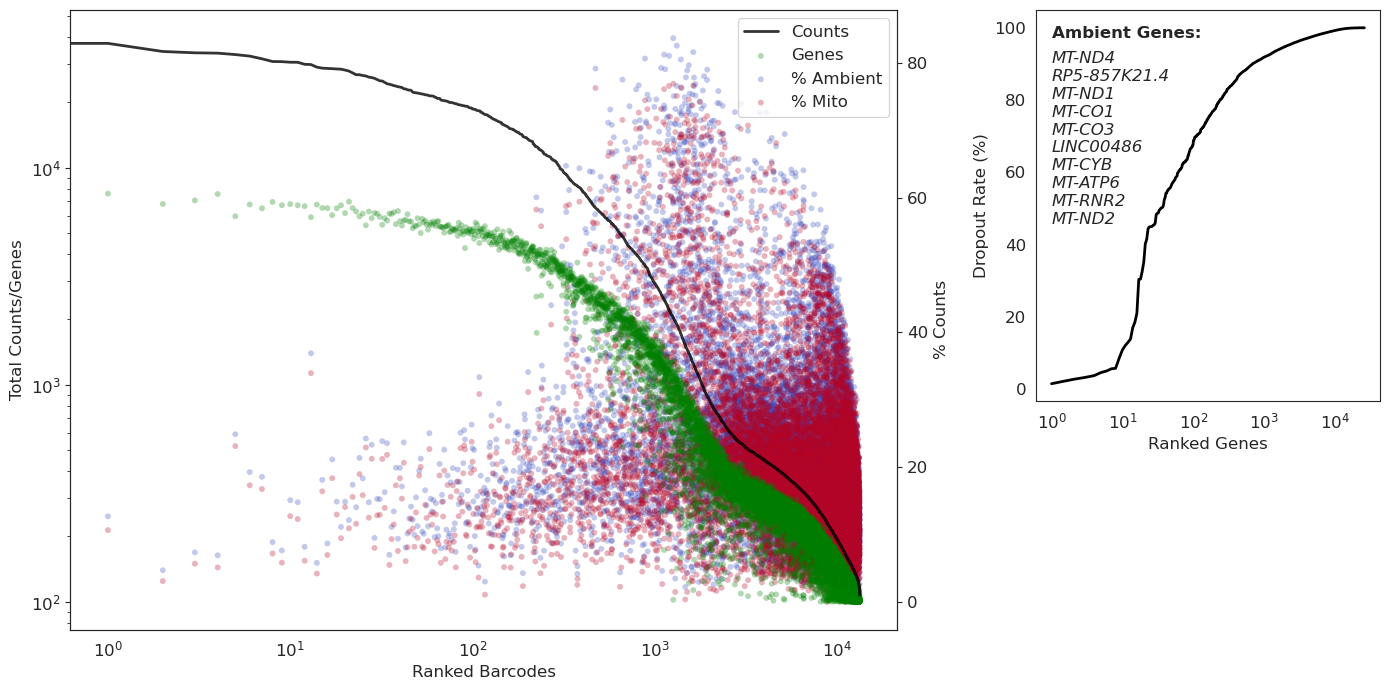

In [18]:
qc_plt2 = dk.qc_summary(a2)

**S3 DMS53_Hes1ko**

In [19]:
a3 = dk.recipe_dropkick(s3, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 0.357 and 11.632 percent:
	['LINC00486', 'RP5-857K21.4', 'MT-ND1', 'MT-ND4', 'MT-CO1', 'ZNF730', 'MT-CO3', 'MT-CYB', 'MT-ATP6', 'MT-ND2']


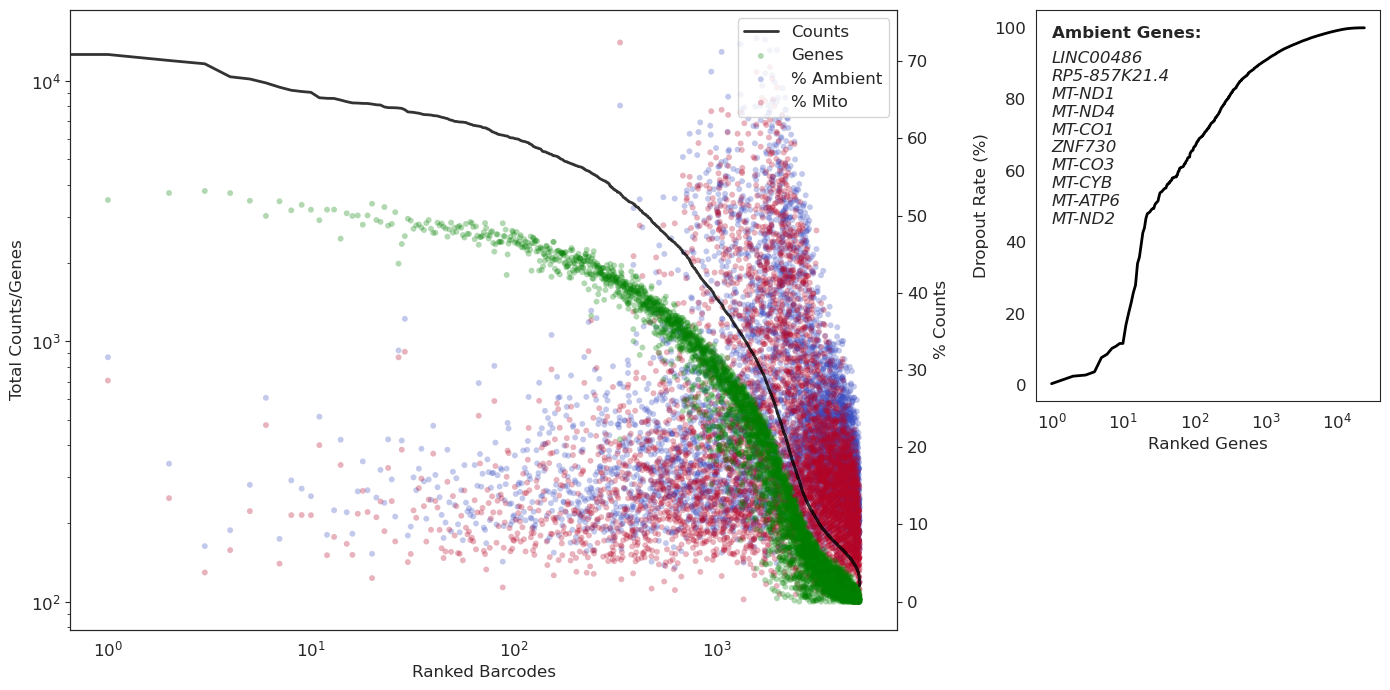

In [20]:
qc_plt3 = dk.qc_summary(a3)

**S4 DMS53_NR0B1ko**

In [21]:
a4 = dk.recipe_dropkick(s4, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 2.776 and 9.03 percent:
	['LINC00486', 'MT-ND4', 'MT-CO1', 'RP5-857K21.4', 'MT-ND1', 'MT-CO3', 'CALCA', 'MT-CYB', 'MT-ATP6', 'MT-ND2']


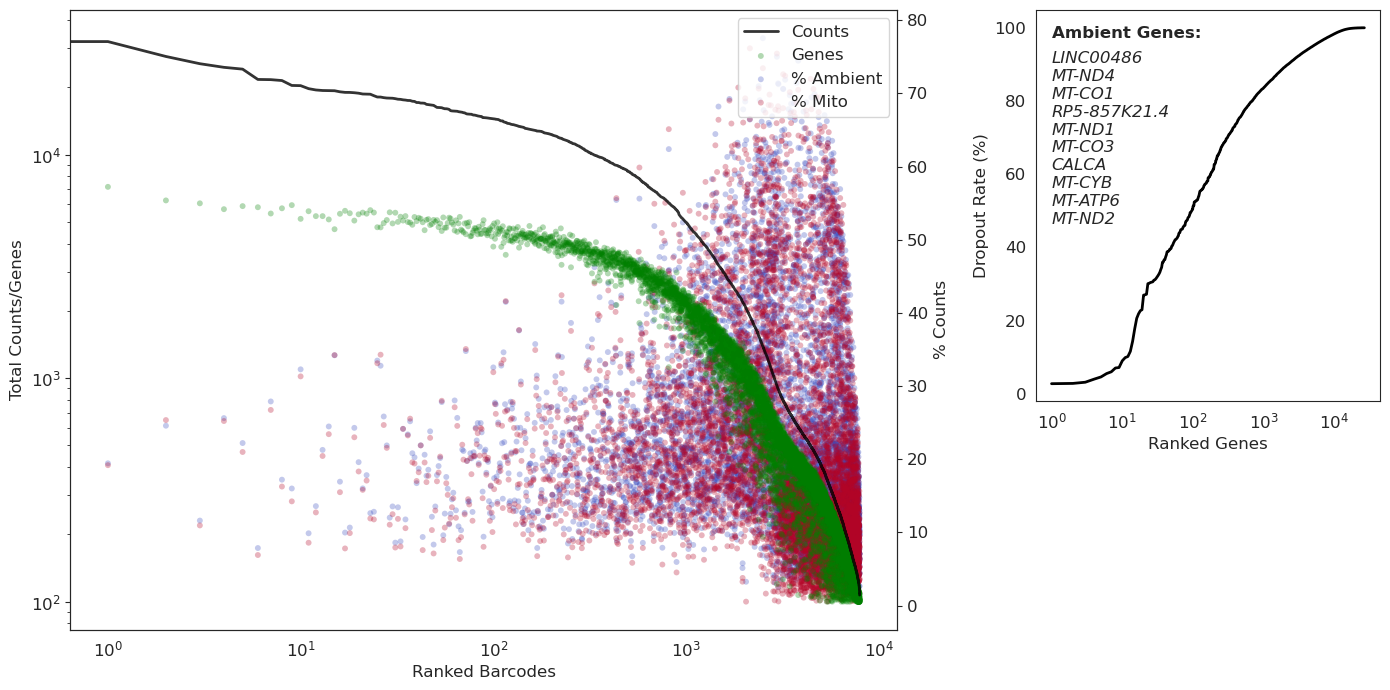

In [22]:
qc_plt4 = dk.qc_summary(a4)

**S5 DMS53_ELF3ko**

In [23]:
a5 = dk.recipe_dropkick(s5, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 1.86 and 10.232 percent:
	['LINC00486', 'MT-CO1', 'RP5-857K21.4', 'MT-ND4', 'CALCA', 'MT-ND1', 'MT-CO3', 'MT-RNR2', 'MT-CYB', 'CGA']


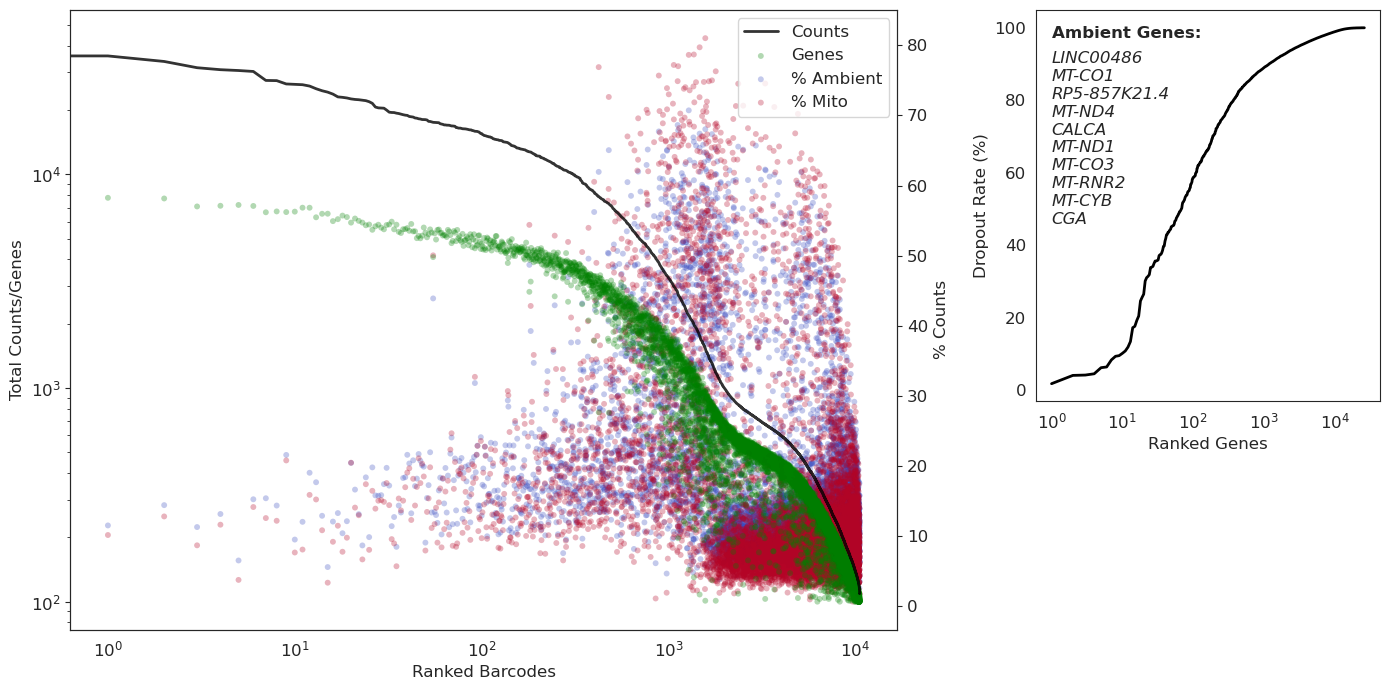

In [24]:
qc_plt5 = dk.qc_summary(a5)

In [7]:
batch_categories = ["S1 DMS53_KOR", "S2 DMS53_RESTko", "S3 DMS53_Hes1ko", "S4 DMS53_NR0B1ko", "S5 DMS53_ELF3ko"]
batch_key = "AW_DMS53_sample"
adata = dropkick_recipe([s1, s2, s3, s4, s5], verbose=True, filter=False, batch_categories=batch_categories, batch_key=batch_key, X_final='log1p_norm', plot=False, n_hvgs=None)

Running dropkick on each sample and filtering...
Top 10 ambient genes have dropout rates between 5.997 and 18.349 percent:
	['LINC00486', 'MT-ND4', 'CALCA', 'SEC11C', 'CGA', 'MT-ND1', 'MT-CO1', 'BCOR', 'MT-CYB', 'RP5-857K21.4']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 5034 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.2min finished


Chosen lambda value:
	[0.0263538]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 1.511 and 10.862 percent:
	['MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'LINC00486', 'MT-CYB', 'MT-ATP6', 'MT-RNR2', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 6074 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.2min finished


Chosen lambda value:
	[0.02308213]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 0.357 and 11.632 percent:
	['LINC00486', 'RP5-857K21.4', 'MT-ND1', 'MT-ND4', 'MT-CO1', 'ZNF730', 'MT-CO3', 'MT-CYB', 'MT-ATP6', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 2987 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.1s finished


Chosen lambda value:
	[0.14073525]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 2.776 and 9.03 percent:
	['LINC00486', 'MT-ND4', 'MT-CO1', 'RP5-857K21.4', 'MT-ND1', 'MT-CO3', 'CALCA', 'MT-CYB', 'MT-ATP6', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 2820 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   54.4s finished


Chosen lambda value:
	[0.04179188]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 1.86 and 10.232 percent:
	['LINC00486', 'MT-CO1', 'RP5-857K21.4', 'MT-ND4', 'CALCA', 'MT-ND1', 'MT-CO3', 'MT-RNR2', 'MT-CYB', 'CGA']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 4434 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished


Chosen lambda value:
	[0.02026937]
Assigning scores and labels
Done!

AnnData object with n_obs × n_vars = 49461 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko'
Filtering and normalizing concatenated data...
Ignoring 37 barcodes with less than 100 genes detected
AnnData object with n_obs × n_vars = 49424 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko'
    layers: 'raw_counts'
Top 10 ambient genes have dropout rates between 3.753 and 15.146 percent:
	['LINC00486', 'MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'MT-CYB', 'CAL

In [8]:
adata

AnnData object with n_obs × n_vars = 49424 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

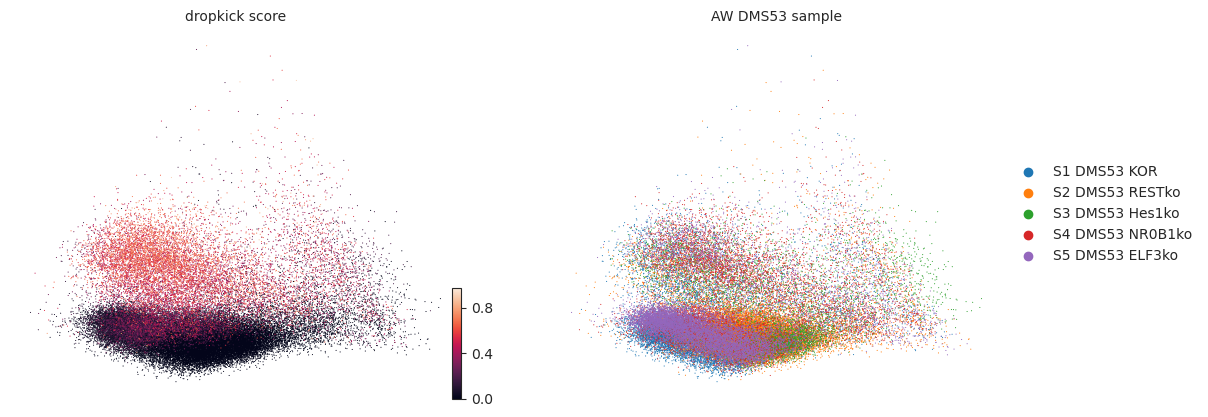

In [9]:
scv.pl.pca(adata, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right')

In [10]:
scv.pp.neighbors(adata, random_state=0)
scv.tl.umap(adata, random_state=0)

computing neighbors
    finished (0:00:30) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


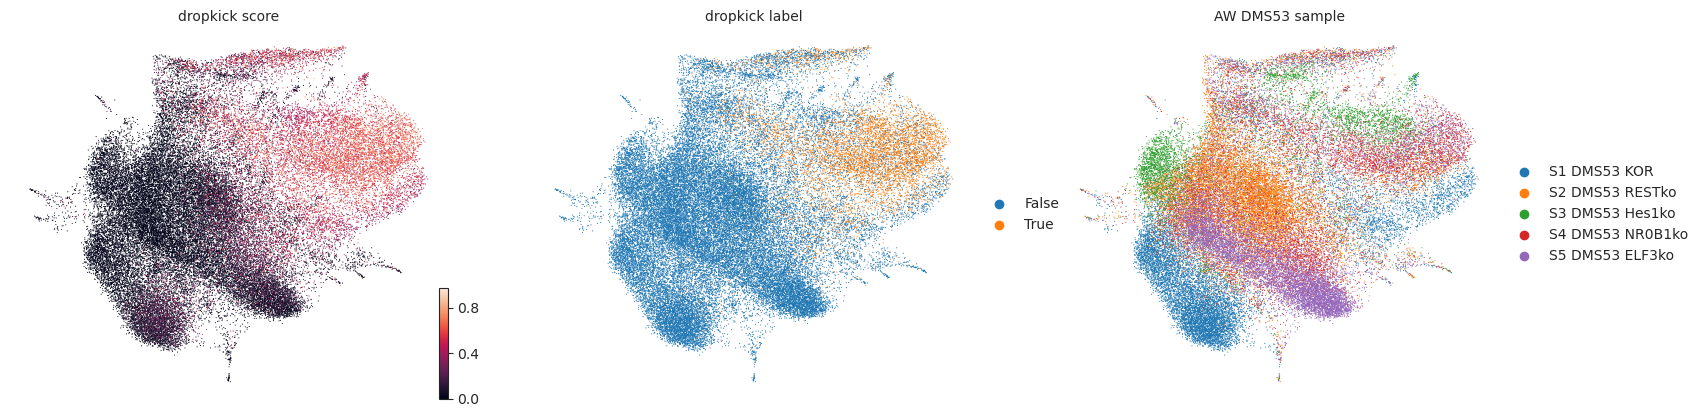

In [11]:
scv.pl.umap(adata, color = ['dropkick_score','dropkick_label','AW_DMS53_sample'], legend_loc = 'on right')

In [12]:
# clustering on unfiltered sample data
sc.tl.leiden(adata, resolution=0.5)

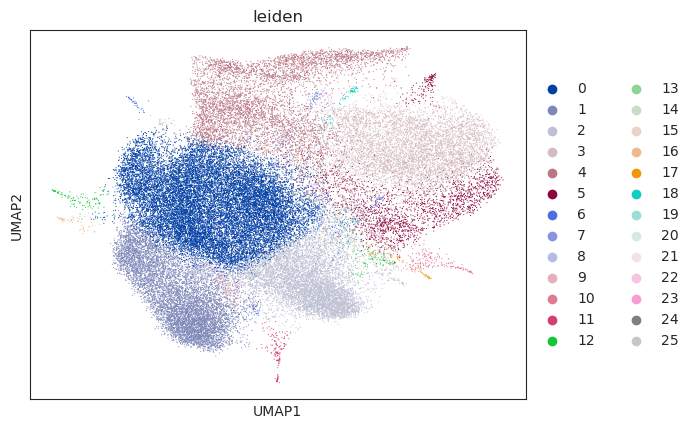

In [13]:
sc.pl.umap(adata, color='leiden')

In [14]:
sc.tl.rank_genes_groups(adata, groupby='leiden', reference='1')

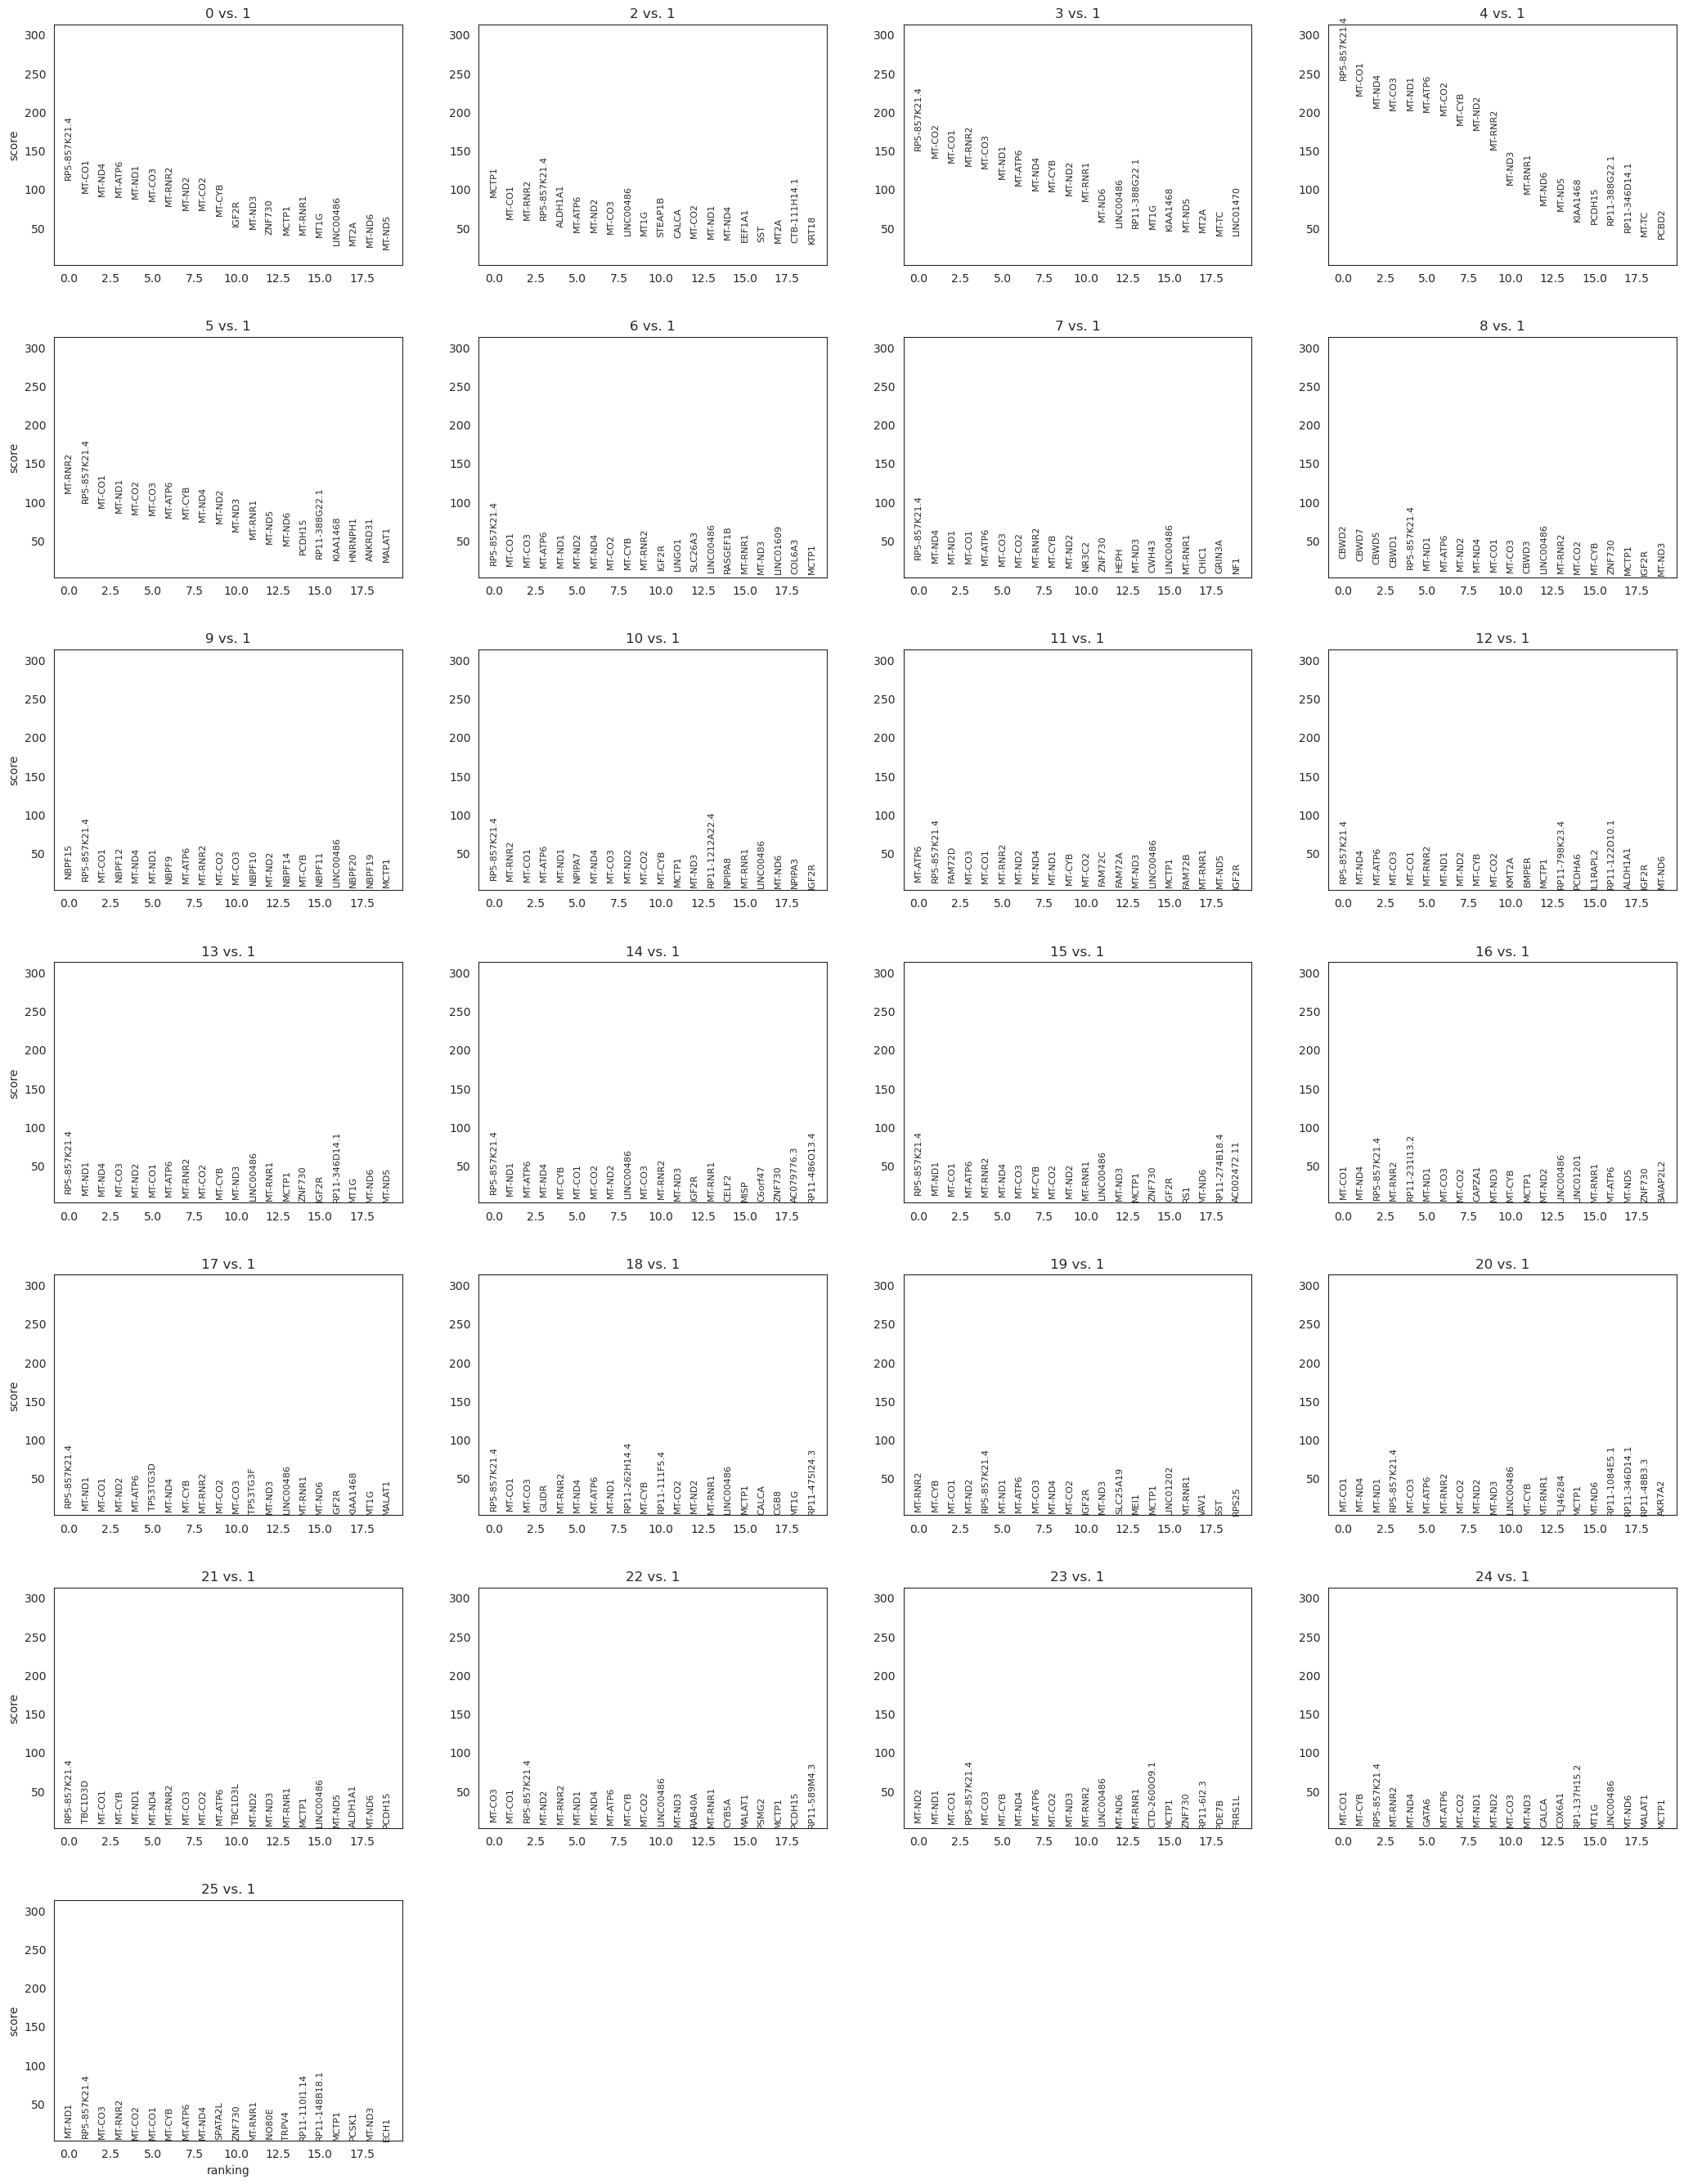

In [15]:
sc.pl.rank_genes_groups(adata, groupby='leiden')

### dropkick Filtering

In [16]:
adata_dk = adata[adata.obs.dropkick_label=='True'].copy()

In [17]:
scv.pp.pca(adata_dk, random_state=0)

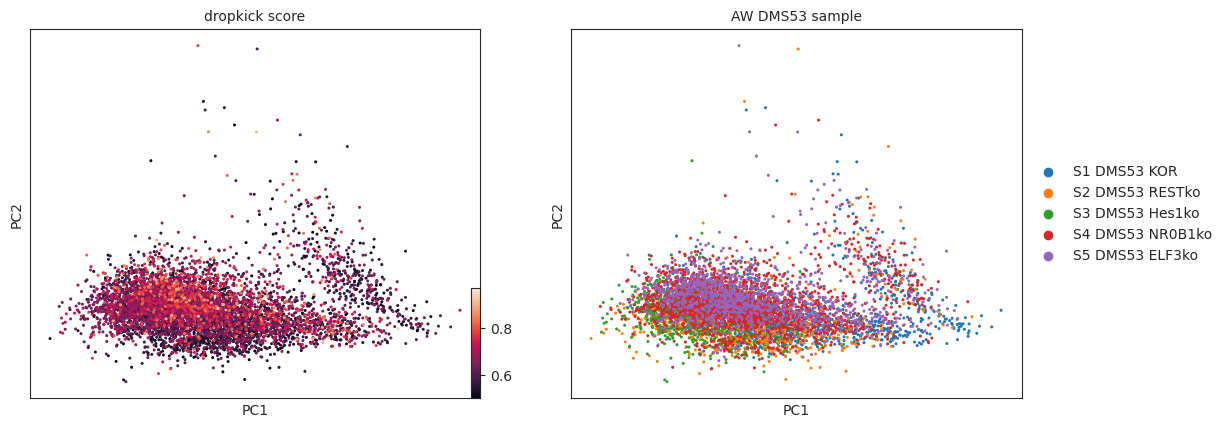

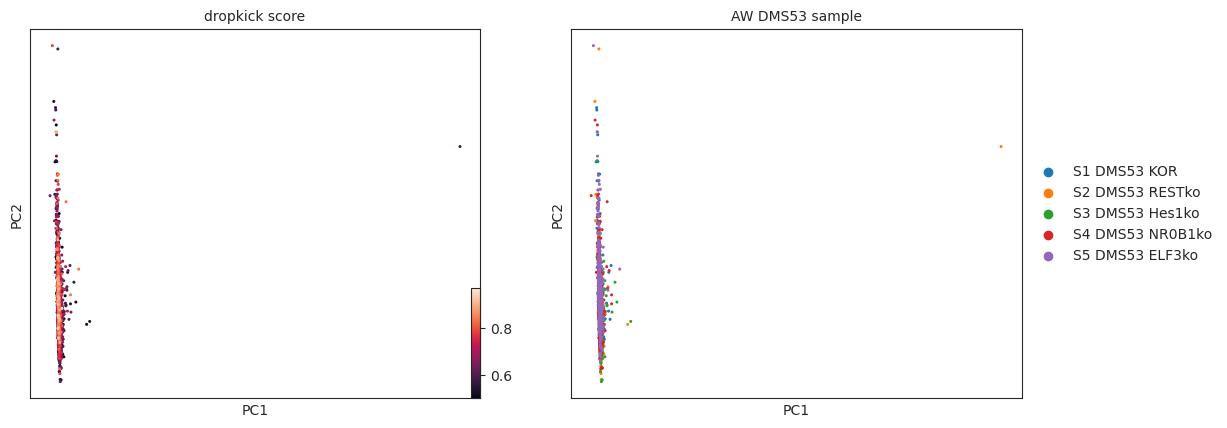

In [18]:
scv.pl.pca(adata_dk, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right', components="1,2", frameon=True)
scv.pl.pca(adata_dk, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right', components="3,2", frameon = True)

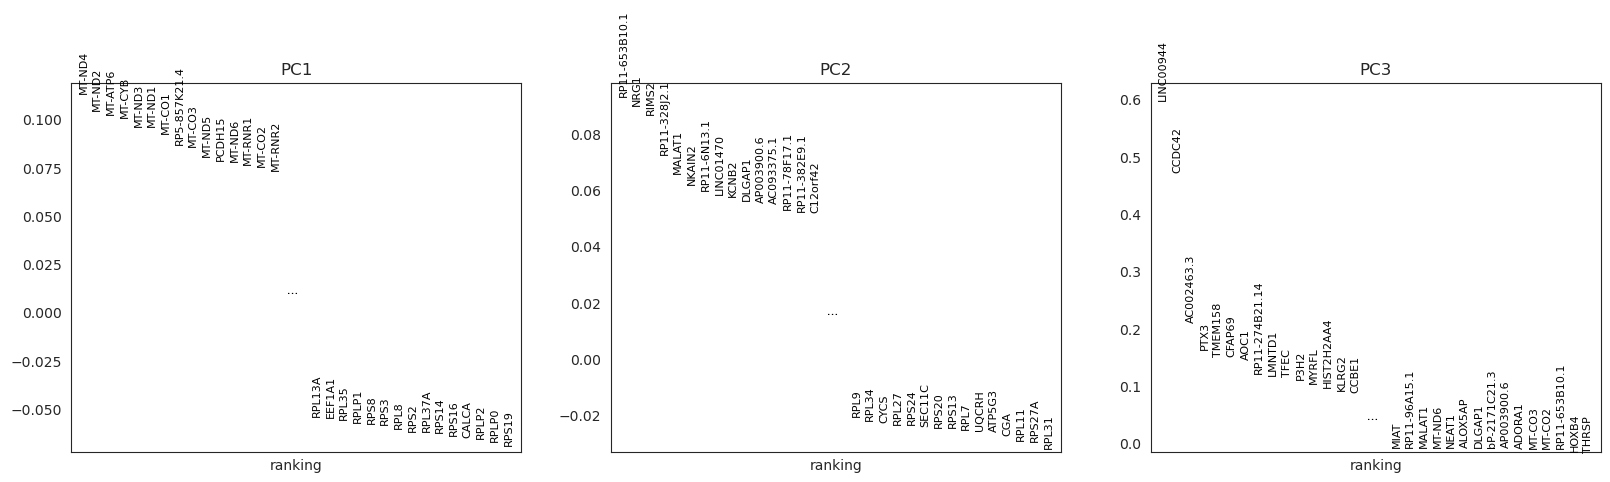

In [19]:
sc.pl.pca_loadings(adata_dk)

In [20]:
scv.pp.neighbors(adata_dk, random_state=0)
scv.tl.umap(adata_dk, random_state=0)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


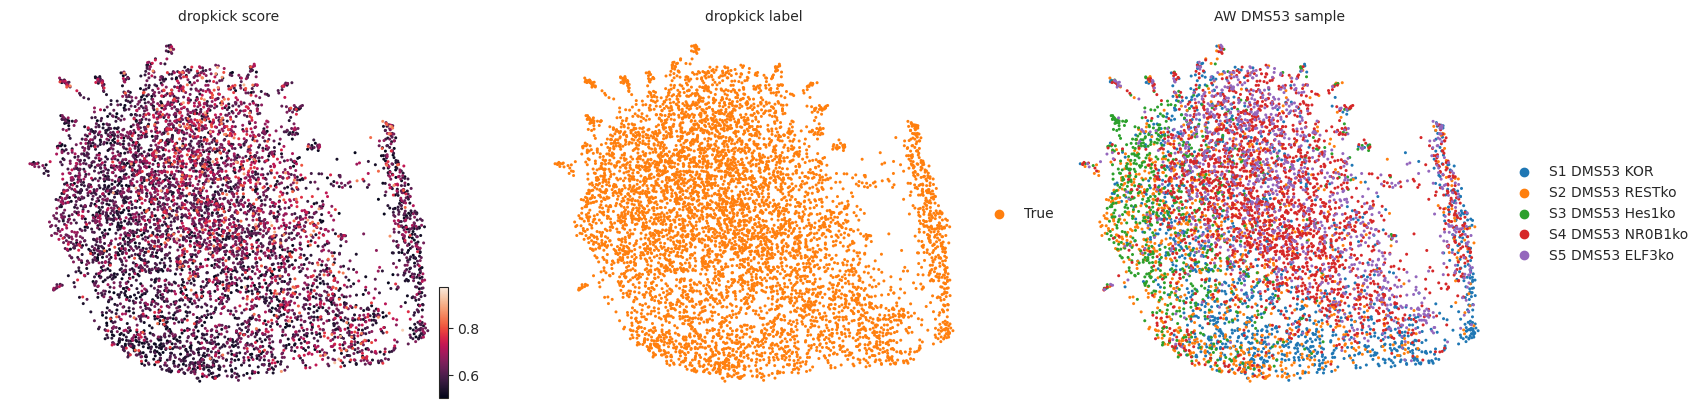

In [21]:
scv.pl.umap(adata_dk, color = ['dropkick_score','dropkick_label','AW_DMS53_sample'], legend_loc = 'on right')

In [16]:
#adata_dk.write_h5ad('/home/monica/rna_seq/adata_dk_01.h5ad')

In [22]:
adata_dk

AnnData object with n_obs × n_vars = 6356 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 

In [23]:
ref_adata

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_

### Integrate with scanorama

Running `correct_scanpy` with the `adata_dk` and `ref_adata`

In [24]:
# correct between Clayton's samples and sarah's
batches = ['AW_DMS53_sample', 'ref_sample']

alldata = {}
alldata[batches[0]] = adata_dk
alldata[batches[1]] = ref_adata

# convert to list of AnnData objects
adatas = list(alldata.values())
adatas

[AnnData object with n_obs × n_vars = 6356 × 21758
     obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
     var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
     uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'raw_counts', 'arcsinh_

In [25]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 15746 genes among all datasets
[[0.         0.25629327]
 [0.         0.        ]]
Processing datasets (0, 1)


In [26]:
corrected

[AnnData object with n_obs × n_vars = 6356 × 15746
     obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
     var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
     uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
     obsm: 'X_pca', 'X_umap', 'X_scanorama',
 AnnData object with n_obs × n_vars =

In [27]:
first = corrected.pop(0)
adata_SC = first.concatenate(corrected, batch_key='sample', batch_categories=batches)

In [28]:
adata_SC.obs_names = [i.rsplit('-',1)[0] for i in adata_SC.obs_names]

In [29]:
# .X corrected full dataset
# .obsm['X_scanorama'] is the dimensionality reduced corrected data
adata_dk.obsm['corrected'] = adata_SC[adata_dk.obs_names,:].X
adata_dk.obsm['X_scanorama'] = adata_SC[adata_dk.obs_names,:].obsm['X_scanorama']

In [30]:
#save gene list for obsm['corrected'] 
adata_dk.uns['corrected_genes'] = list(adata_SC.var_names)

In [31]:
sc.pp.neighbors(adata_dk, use_rep="X_scanorama", key_added='scanorama_neighbors')
tmp = sc.tl.umap(adata_dk, neighbors_key='scanorama_neighbors', random_state=0, copy=True)
adata_dk.obsm['X_scanorama_umap'] = tmp.obsm['X_umap']
del tmp

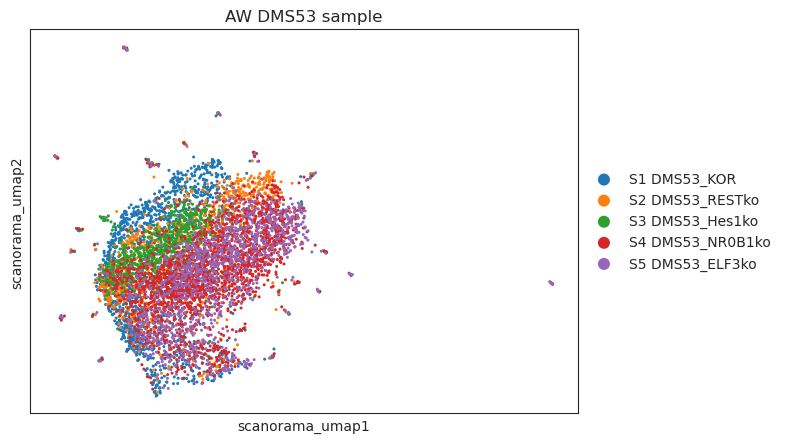

In [32]:
sc.pl.scatter(adata_dk, basis='scanorama_umap',color='AW_DMS53_sample')

In [33]:
adata_SC

AnnData object with n_obs × n_vars = 20301 × 15746
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score', 'sample'
    var: 'mito', 'dropkick_coef-S1 DMS53_KOR-AW_DMS53_sample', 'dropkick_coef-S2 DMS53_RESTko-AW_DMS53_sample', 'dropkick_coef-S3 DMS53_Hes1ko-AW_DMS53_sample', 'dropkick_coef-S4 DMS53_NR0B1ko-AW_DMS53_sample', 'dropkick_coef-S5 DMS53_ELF3ko-AW_DMS53_sample', 'pct_dropout_by_counts-AW_DMS53_sample', 'ambient-AW_DMS53_sample', 

In [34]:
sc.pp.neighbors(adata_SC, use_rep="X_scanorama", key_added='scanorama_neighbors')

In [35]:
temp = sc.tl.umap(adata_SC, neighbors_key='scanorama_neighbors', random_state=0, copy=True)
adata_SC.obsm['X_scanorama_umap'] = temp.obsm['X_umap']
del temp

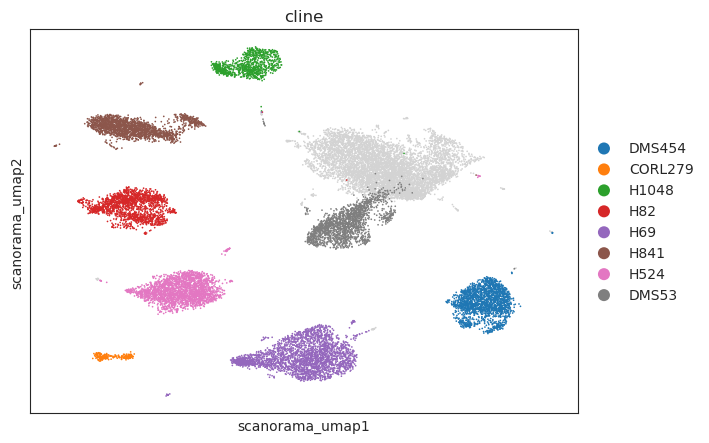

In [36]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color='cline', save='_all_cell_lines.png')

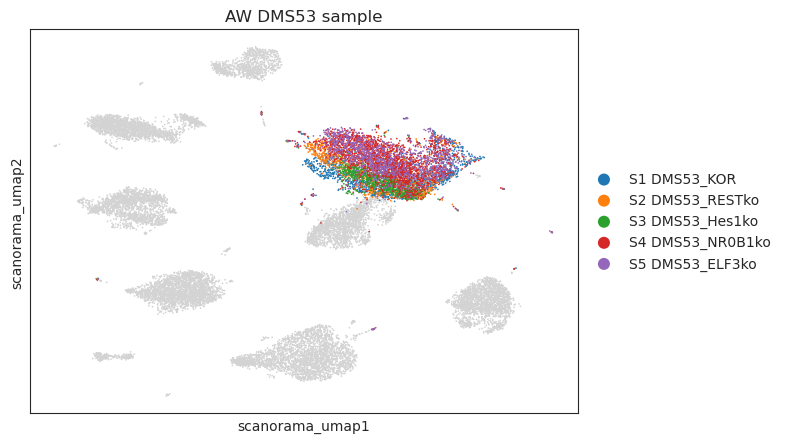

In [37]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], save='_clayton_all_DMS53.png')

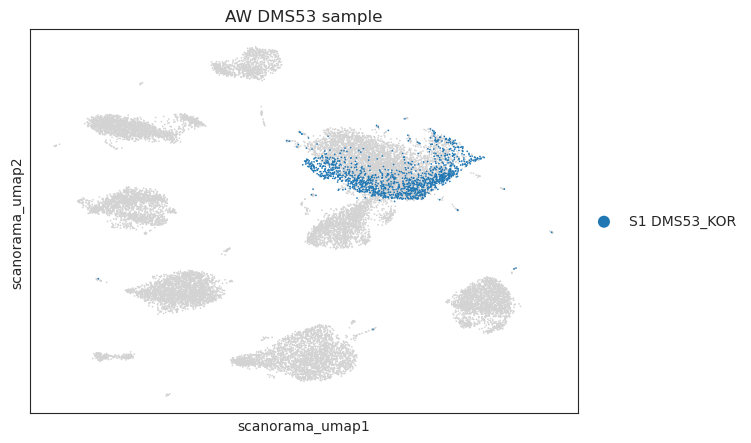

In [39]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S1 DMS53_KOR', save='DMS53_KOR.png')

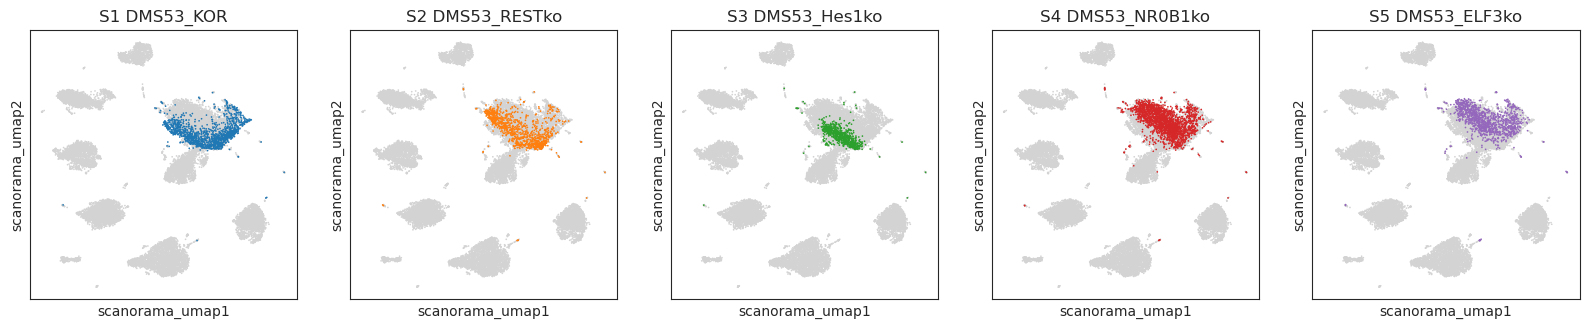

In [38]:
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))#, gridspec_kw={'wspace':0.8})
ax1_dict = sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S1 DMS53_KOR', ax=ax1, show=False, title=['S1 DMS53_KOR'], legend_loc='none')
ax2_dict = sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S2 DMS53_RESTko', ax=ax2, show=False, title=['S2 DMS53_RESTko'], legend_loc='none')
ax3_dict = sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S3 DMS53_Hes1ko', ax=ax3, show=False, title=['S3 DMS53_Hes1ko'], legend_loc='none')
ax4_dict = sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S4 DMS53_NR0B1ko', ax=ax4, show=False, title=['S4 DMS53_NR0B1ko'], legend_loc='none')
ax5_dict = sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S5 DMS53_ELF3ko', ax=ax5, show=False, title=['S5 DMS53_ELF3ko'], legend_loc='none')

---
## PCA Visualizations

In [40]:
# 1. running a PCA on the “corrected” layer in filtered sample adata 
tmp = sc.tl.pca(adata_dk.obsm['corrected'])
adata_dk.obsm['X_scanorama_pca'] = tmp
del tmp
adata_dk

AnnData object with n_obs × n_vars = 6356 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'corrected_genes', 'scanorama_neighbors'
    obsm: 'X_pca', 'X_umap', 'corrected', 'X

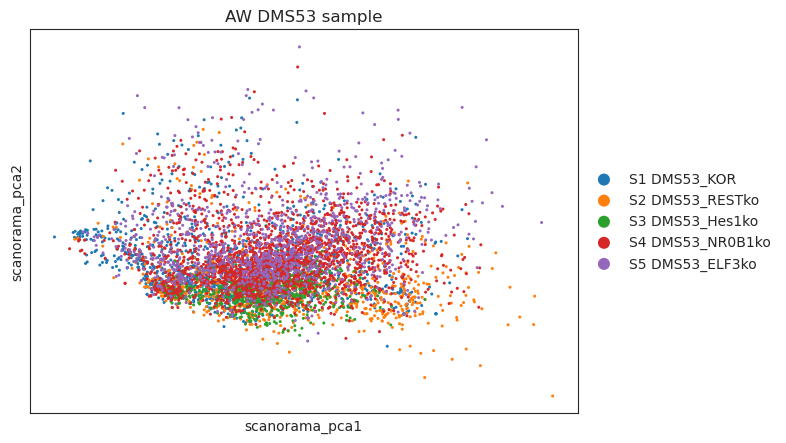

In [41]:
sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'])

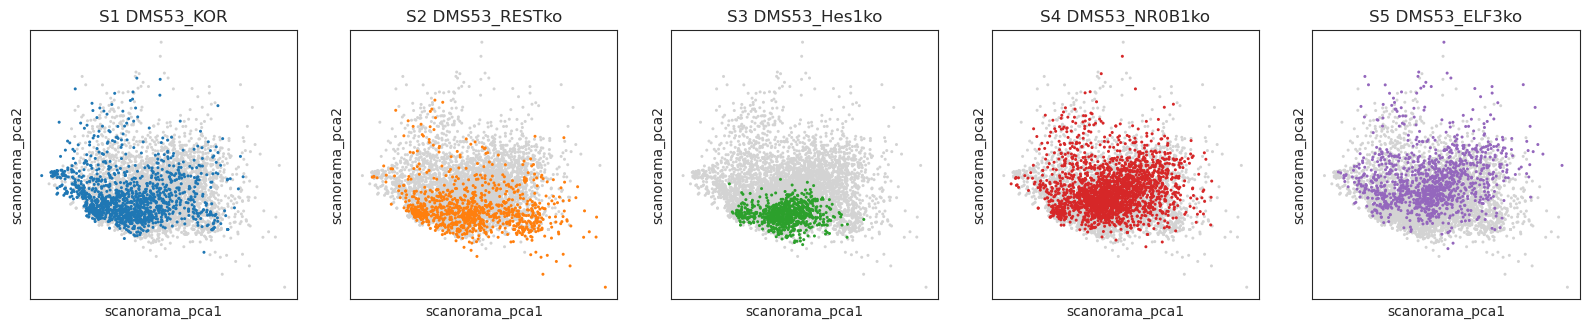

In [42]:
fig2, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))#, gridspec_kw={'wspace':0.8})
ax1_dict = sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'], groups='S1 DMS53_KOR', ax=ax1, show=False, title=['S1 DMS53_KOR'], legend_loc='none')
ax2_dict = sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'], groups='S2 DMS53_RESTko', ax=ax2, show=False, title=['S2 DMS53_RESTko'], legend_loc='none')
ax3_dict = sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'], groups='S3 DMS53_Hes1ko', ax=ax3, show=False, title=['S3 DMS53_Hes1ko'], legend_loc='none')
ax4_dict = sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'], groups='S4 DMS53_NR0B1ko', ax=ax4, show=False, title=['S4 DMS53_NR0B1ko'], legend_loc='none')
ax5_dict = sc.pl.scatter(adata_dk, basis='scanorama_pca',color=['AW_DMS53_sample'], groups='S5 DMS53_ELF3ko', ax=ax5, show=False, title=['S5 DMS53_ELF3ko'], legend_loc='none')

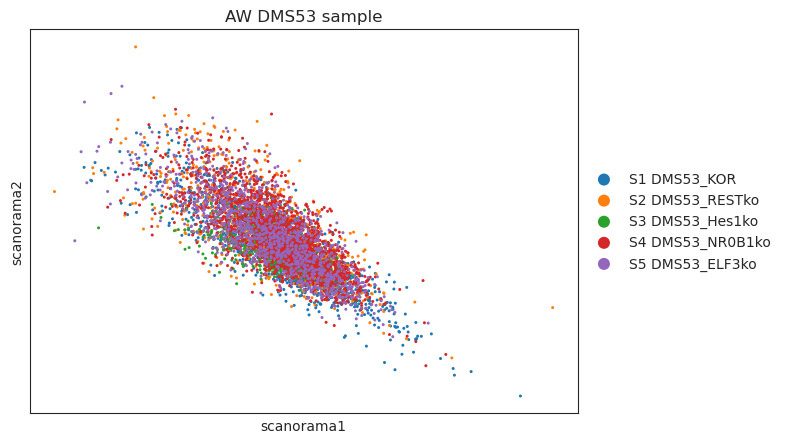

In [43]:
# 2. Visualizing the “X_scanorama” layer (the dimensionality reduced corrected data)
sc.pl.scatter(adata_dk, basis='scanorama',color=['AW_DMS53_sample'])

In [44]:
# 3. running PCA on adata_SC (integrated data)
sc.tl.pca(adata_SC)
adata_SC

AnnData object with n_obs × n_vars = 20301 × 15746
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score', 'sample'
    var: 'mito', 'dropkick_coef-S1 DMS53_KOR-AW_DMS53_sample', 'dropkick_coef-S2 DMS53_RESTko-AW_DMS53_sample', 'dropkick_coef-S3 DMS53_Hes1ko-AW_DMS53_sample', 'dropkick_coef-S4 DMS53_NR0B1ko-AW_DMS53_sample', 'dropkick_coef-S5 DMS53_ELF3ko-AW_DMS53_sample', 'pct_dropout_by_counts-AW_DMS53_sample', 'ambient-AW_DMS53_sample', 

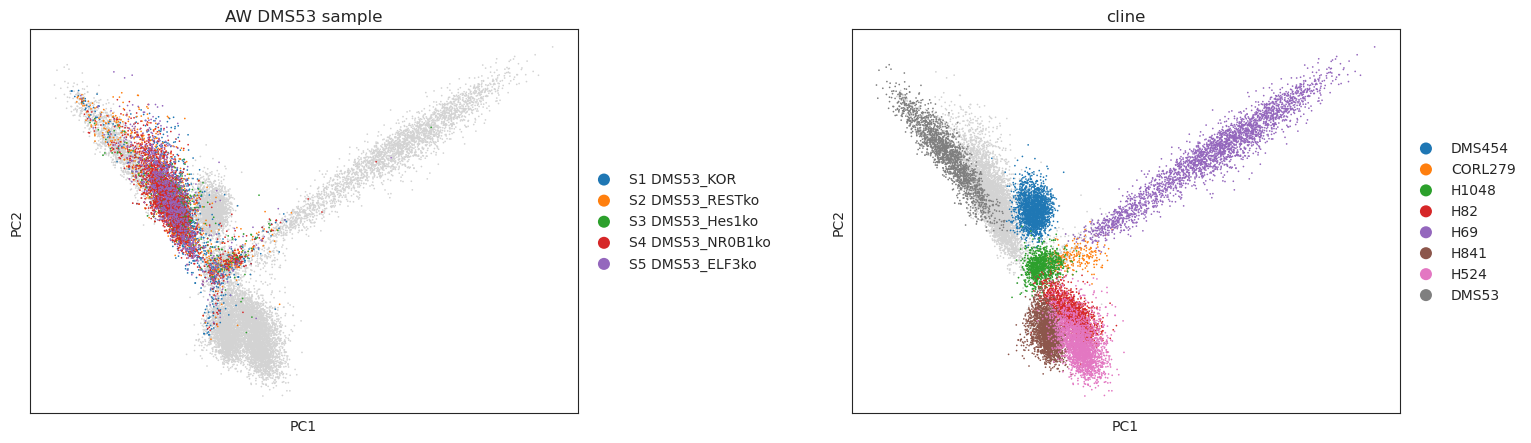

In [48]:
sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample', 'cline'])

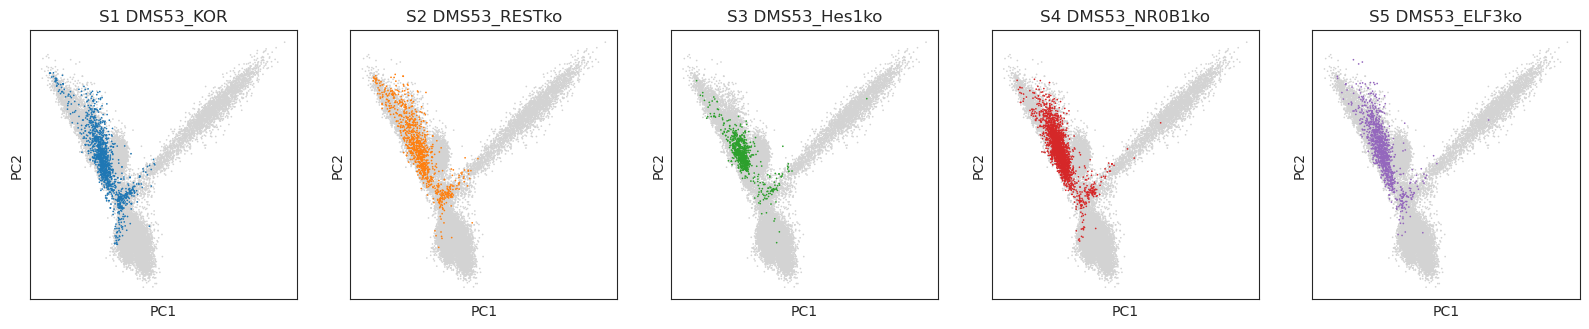

In [49]:
fig3, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3.5))#, gridspec_kw={'wspace':0.8})
ax1_dict = sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample'], groups='S1 DMS53_KOR', ax=ax1, show=False, title=['S1 DMS53_KOR'], legend_loc='none')
ax2_dict = sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample'], groups='S2 DMS53_RESTko', ax=ax2, show=False, title=['S2 DMS53_RESTko'], legend_loc='none')
ax3_dict = sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample'], groups='S3 DMS53_Hes1ko', ax=ax3, show=False, title=['S3 DMS53_Hes1ko'], legend_loc='none')
ax4_dict = sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample'], groups='S4 DMS53_NR0B1ko', ax=ax4, show=False, title=['S4 DMS53_NR0B1ko'], legend_loc='none')
ax5_dict = sc.pl.scatter(adata_SC, basis='pca',color=['AW_DMS53_sample'], groups='S5 DMS53_ELF3ko', ax=ax5, show=False, title=['S5 DMS53_ELF3ko'], legend_loc='none')

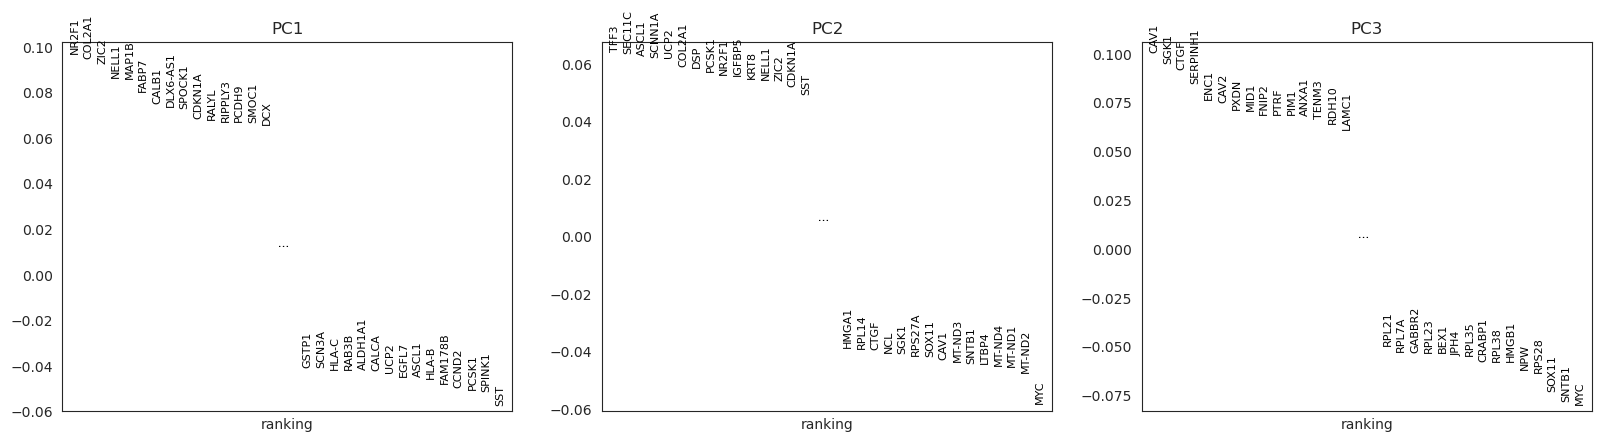

In [51]:
sc.pl.pca_loadings(adata_SC)

In [52]:
sc.tl.embedding_density(adata_SC, basis='pca', groupby='AW_DMS53_sample')

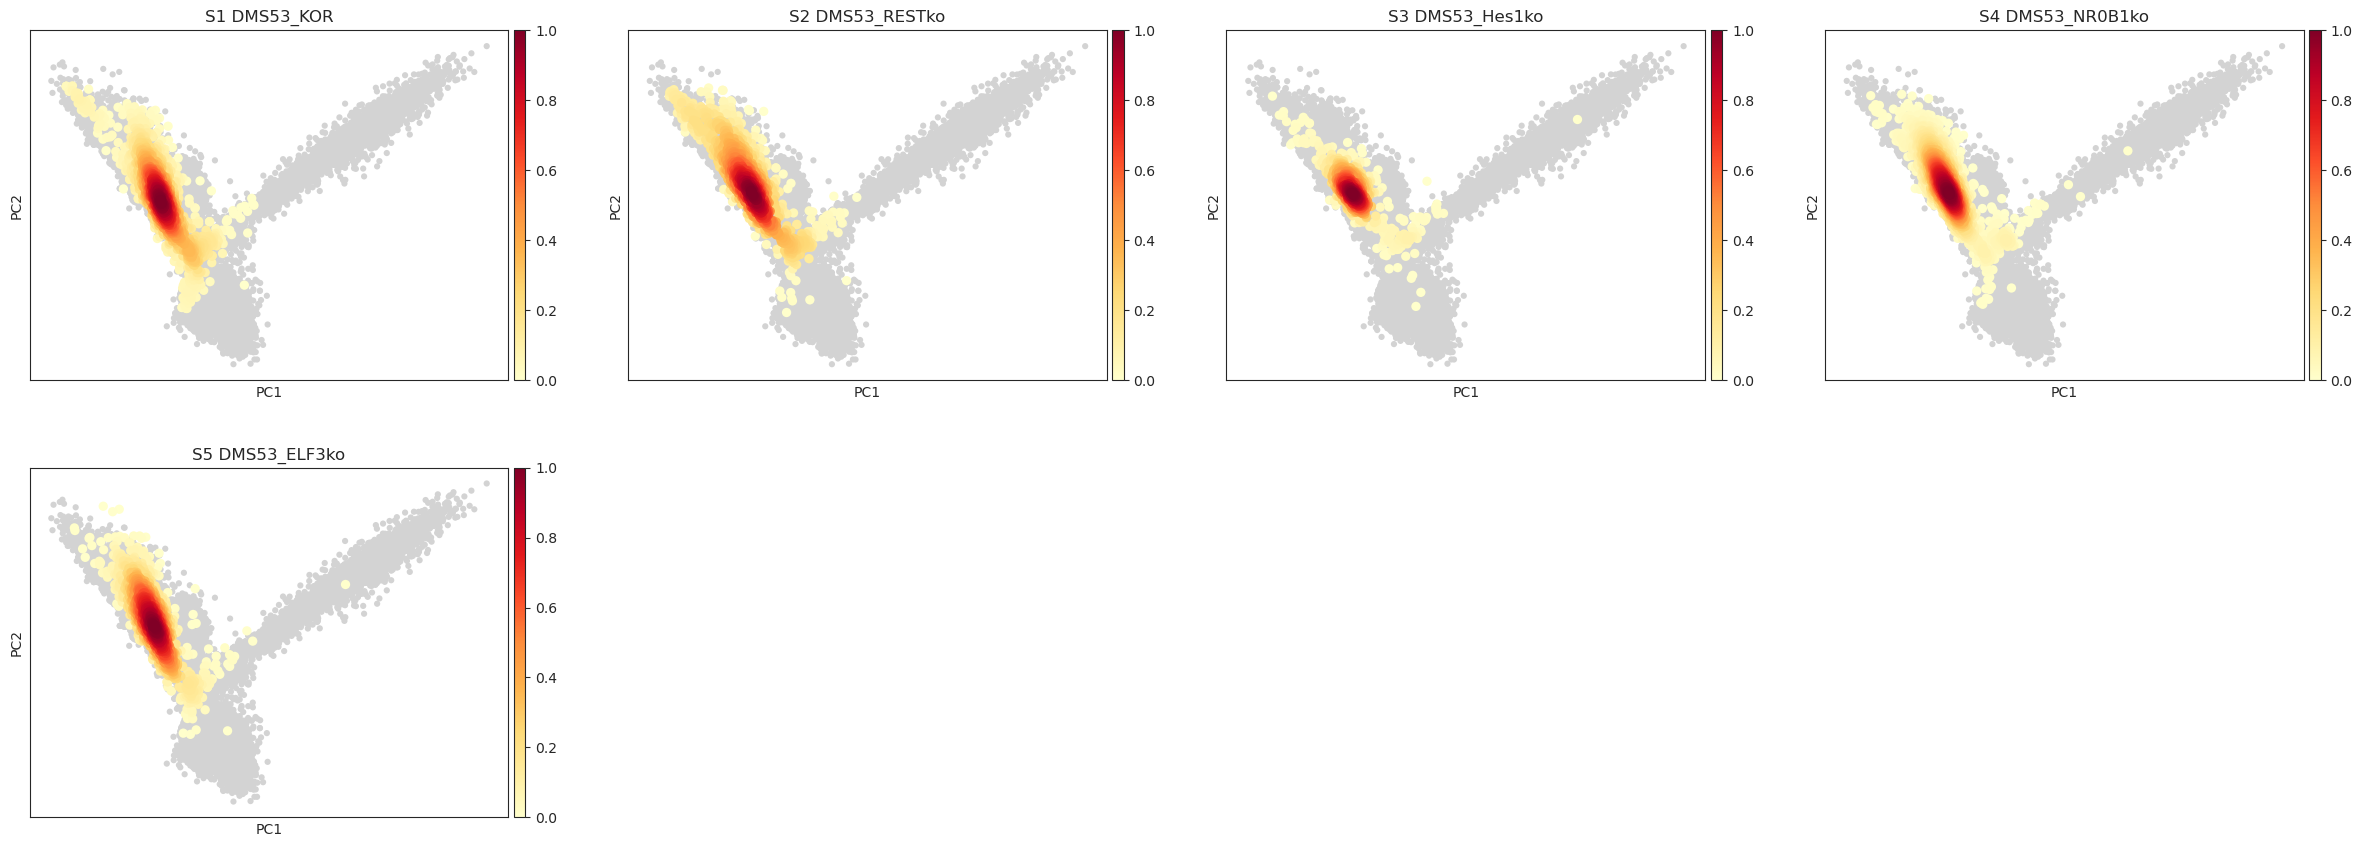

In [53]:
sc.pl.embedding_density(adata_SC, key='pca_density_AW_DMS53_sample', basis='pca')

In [54]:
# get pca data just for AW_DMS53 samples 
plotdf = sc.get.obs_df(
        adata_SC,
        keys=['AW_DMS53_sample'],
        obsm_keys=[("X_pca", 0), ("X_pca", 1)])

In [55]:
plotdf

AW_DMS53_sample   X_pca-0  \
AAATGACCCGTTCTGTT-S1 DMS53_KOR                 S1 DMS53_KOR -0.017522   
AAGCGCCTTCGCTCTCA-S1 DMS53_KOR                 S1 DMS53_KOR -0.042468   
GACCACATTACGGCTTAC-S1 DMS53_KOR                S1 DMS53_KOR -0.017929   
TGATGTGGCTATCGACACC-S1 DMS53_KOR               S1 DMS53_KOR  0.067076   
ATCTGCATCACACTAAG-S1 DMS53_KOR                 S1 DMS53_KOR  0.005497   
...                                                     ...       ...   
2639-SM-2-CTTGTA_S2:TTTGTGTCGGCCCTTAx-DMS53             NaN -0.113433   
2639-SM-2-CTTGTA_S2:TTTGTGTCCACAAGGCx-DMS53             NaN -0.100685   
2639-SM-2-CTTGTA_S2:TTTGTGTCCTGTTCTTx-DMS53             NaN -0.115386   
2639-SM-2-CTTGTA_S2:TTTGTGTCCCCATCTGx-DMS53             NaN -0.112222   
2639-SM-2-CTTGTA_S2:TTTGTGTCCAGTTTGCx-DMS53             NaN -0.197025   

                                              X_pca-1  
AAATGACCCGTTCTGTT-S1 DMS53_KOR              -0.065373  
AAGCGCCTTCGCTCTCA-S1 DMS53_KOR              -0.064792  
GACCACATTACGGCTTAC-S1 DMS53_KOR             -0.047085  
TGATGTGGCTATCGACACC-S1 DMS53_KOR             0.009072  
ATCTGCATCACACTAAG-S1 DMS53_KOR              -0.036099  
...                                               ...  
2639-SM-2-CTTGTA_S2:TTTGTGTCGGCCCTTAx-DMS53  0.093708  
2639-SM-2-CTTGTA_S2:TTTGTGTCCACAAGGCx-DMS53  0.080874  
2639-SM-2-CTTGTA_S2:TTTGTGTCCTGTTCTTx-DMS53  0.088201  
2639-SM-2-CTTGTA_S2:TTTGTGTCCCCATCTGx-DMS53  0.050045  
2639-SM-2-CTTGTA_S2:TTTGTGTCCAGTTTGCx-DMS53  0.173917  

[20301 rows x 3 columns]

**KOR plots**

In [56]:
df_kor = plotdf[plotdf.AW_DMS53_sample=='S1 DMS53_KOR'].copy()
df_kor

AW_DMS53_sample   X_pca-0   X_pca-1
AAATGACCCGTTCTGTT-S1 DMS53_KOR      S1 DMS53_KOR -0.017522 -0.065373
AAGCGCCTTCGCTCTCA-S1 DMS53_KOR      S1 DMS53_KOR -0.042468 -0.064792
GACCACATTACGGCTTAC-S1 DMS53_KOR     S1 DMS53_KOR -0.017929 -0.047085
TGATGTGGCTATCGACACC-S1 DMS53_KOR    S1 DMS53_KOR  0.067076  0.009072
ATCTGCATCACACTAAG-S1 DMS53_KOR      S1 DMS53_KOR  0.005497 -0.036099
...                                          ...       ...       ...
GGAGAAGCATACTCTT-S1 DMS53_KOR       S1 DMS53_KOR -0.093806  0.157132
AATGCGGATCCATTACT-S1 DMS53_KOR      S1 DMS53_KOR -0.107496  0.147565
GATGTTCCAGAAAGTCGG-S1 DMS53_KOR     S1 DMS53_KOR -0.113266  0.168794
GTACCTTGAAGCTTCT-S1 DMS53_KOR       S1 DMS53_KOR -0.102243  0.164133
CATCGCAGATGCGGAT-S1 DMS53_KOR       S1 DMS53_KOR -0.091906  0.149369

[1344 rows x 3 columns]

<AxesSubplot:xlabel='X_pca-1', ylabel='Count'>

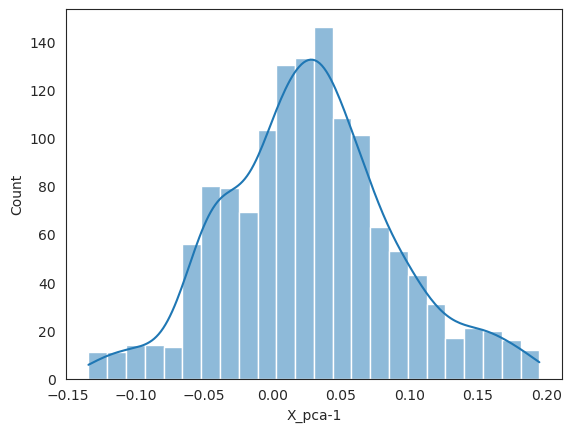

In [57]:
# Add a kernel density estimate to smooth the histogram, 
# providing complementary information about the shape of the distribution:
sns.histplot(data=df_kor, x='X_pca-1', kde=True)

<AxesSubplot:xlabel='X_pca-1', ylabel='Density'>

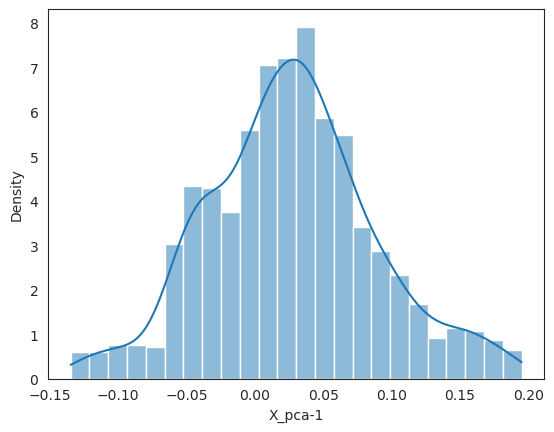

In [58]:
sns.histplot(data=df_kor, x='X_pca-1', kde=True, stat='density')

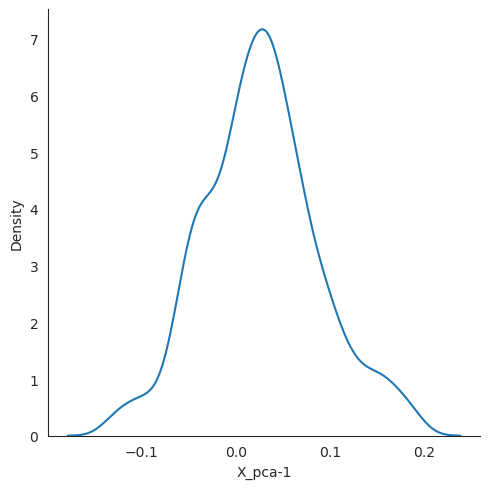

In [59]:
sns.displot(data=df_kor, x="X_pca-1", kind="kde")

**ELF3 plots**

In [60]:
df_elf3 = plotdf[plotdf.AW_DMS53_sample=='S5 DMS53_ELF3ko'].copy()
df_elf3

AW_DMS53_sample   X_pca-0   X_pca-1
ATATGCATTGACCAGT-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.015089 -0.094616
TGATTGCACGCTAAGACGG-S5 DMS53_ELF3ko  S5 DMS53_ELF3ko  0.004110 -0.040219
GAATCAAGTGCTGGTGCA-S5 DMS53_ELF3ko   S5 DMS53_ELF3ko -0.060853  0.015773
GATGTAAAGGTAGAAATG-S5 DMS53_ELF3ko   S5 DMS53_ELF3ko  0.040127  0.000305
TGATGTCTTTCGTAATCCC-S5 DMS53_ELF3ko  S5 DMS53_ELF3ko  0.044797 -0.007848
...                                              ...       ...       ...
CCAACCGTATACCCAG-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.132861  0.161720
GATGTTCCAGGTCCATGT-S5 DMS53_ELF3ko   S5 DMS53_ELF3ko -0.127261  0.149332
GGCCCTTAAGGCAGTT-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.134862  0.212060
CTTTAATCATGAAGCA-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.148913  0.220159
TGAAGCGCGATAGCGCCTT-S5 DMS53_ELF3ko  S5 DMS53_ELF3ko -0.094479  0.176089

[1121 rows x 3 columns]

<AxesSubplot:xlabel='X_pca-1', ylabel='Count'>

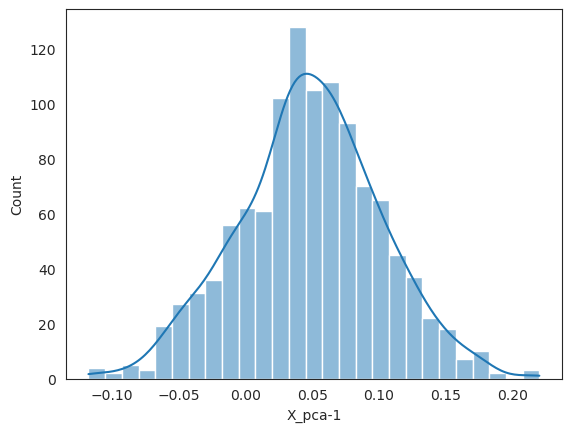

In [61]:
sns.histplot(data=df_elf3, x='X_pca-1', kde=True)

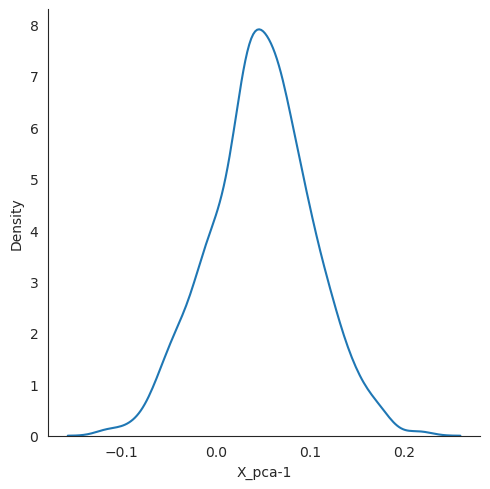

In [62]:
sns.displot(data=df_elf3, x="X_pca-1", kind="kde")

**KOR-ELF**

In [63]:
kor_elf = pd.concat([df_kor, df_elf3])
kor_elf

AW_DMS53_sample   X_pca-0   X_pca-1
AAATGACCCGTTCTGTT-S1 DMS53_KOR          S1 DMS53_KOR -0.017522 -0.065373
AAGCGCCTTCGCTCTCA-S1 DMS53_KOR          S1 DMS53_KOR -0.042468 -0.064792
GACCACATTACGGCTTAC-S1 DMS53_KOR         S1 DMS53_KOR -0.017929 -0.047085
TGATGTGGCTATCGACACC-S1 DMS53_KOR        S1 DMS53_KOR  0.067076  0.009072
ATCTGCATCACACTAAG-S1 DMS53_KOR          S1 DMS53_KOR  0.005497 -0.036099
...                                              ...       ...       ...
CCAACCGTATACCCAG-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.132861  0.161720
GATGTTCCAGGTCCATGT-S5 DMS53_ELF3ko   S5 DMS53_ELF3ko -0.127261  0.149332
GGCCCTTAAGGCAGTT-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.134862  0.212060
CTTTAATCATGAAGCA-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.148913  0.220159
TGAAGCGCGATAGCGCCTT-S5 DMS53_ELF3ko  S5 DMS53_ELF3ko -0.094479  0.176089

[2465 rows x 3 columns]

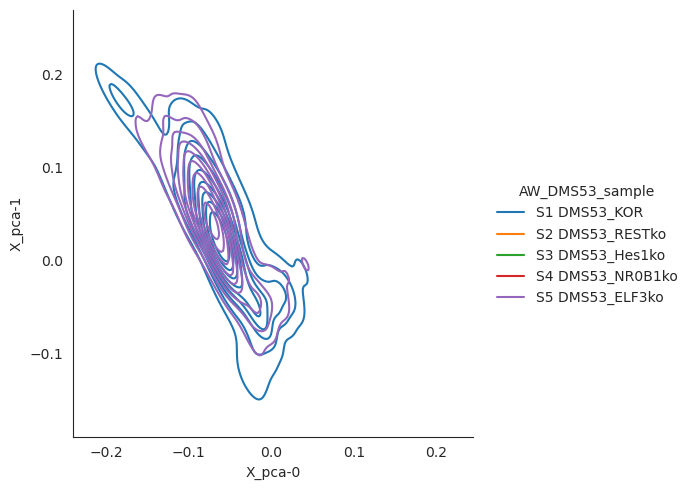

In [64]:
sns.displot(kor_elf, x="X_pca-0", y="X_pca-1", hue="AW_DMS53_sample", kind="kde")

**All Samples**

In [65]:
# first, remove NaN from plotdf
aw_df = plotdf.dropna()
aw_df

AW_DMS53_sample   X_pca-0   X_pca-1
AAATGACCCGTTCTGTT-S1 DMS53_KOR          S1 DMS53_KOR -0.017522 -0.065373
AAGCGCCTTCGCTCTCA-S1 DMS53_KOR          S1 DMS53_KOR -0.042468 -0.064792
GACCACATTACGGCTTAC-S1 DMS53_KOR         S1 DMS53_KOR -0.017929 -0.047085
TGATGTGGCTATCGACACC-S1 DMS53_KOR        S1 DMS53_KOR  0.067076  0.009072
ATCTGCATCACACTAAG-S1 DMS53_KOR          S1 DMS53_KOR  0.005497 -0.036099
...                                              ...       ...       ...
CCAACCGTATACCCAG-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.132861  0.161720
GATGTTCCAGGTCCATGT-S5 DMS53_ELF3ko   S5 DMS53_ELF3ko -0.127261  0.149332
GGCCCTTAAGGCAGTT-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.134862  0.212060
CTTTAATCATGAAGCA-S5 DMS53_ELF3ko     S5 DMS53_ELF3ko -0.148913  0.220159
TGAAGCGCGATAGCGCCTT-S5 DMS53_ELF3ko  S5 DMS53_ELF3ko -0.094479  0.176089

[6356 rows x 3 columns]

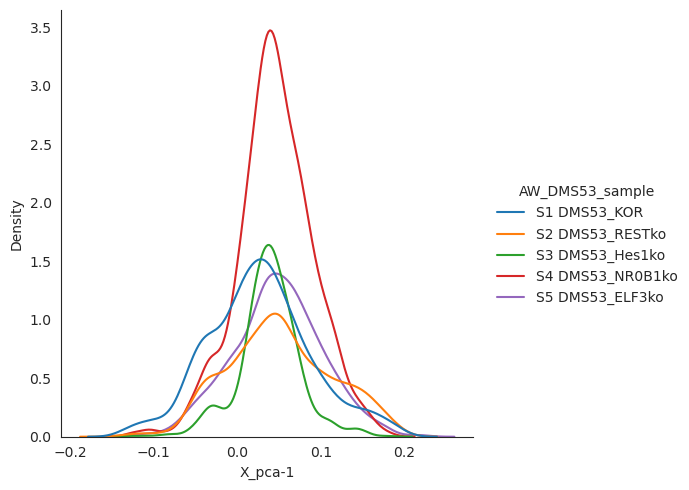

In [66]:
sns.displot(data=aw_df, x="X_pca-1", hue="AW_DMS53_sample", kind="kde")

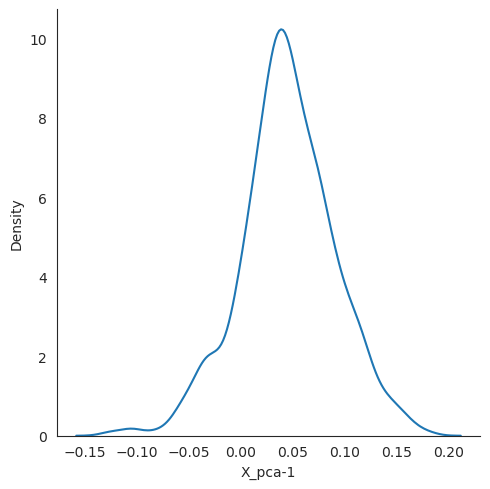

In [67]:
# not sure why individual plots density axis aren't matching the group plot, ex. NR0b1ko
df_nr0b = plotdf[plotdf.AW_DMS53_sample=='S4 DMS53_NR0B1ko'].copy()
sns.displot(data=df_nr0b, x="X_pca-1", kind="kde")